### Imports

In [65]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt

In [13]:
print(tf.config.list_physical_devices('GPU'))
tf.test.is_built_with_cuda()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


True

### Preparing the Data

In [14]:
# Path to training data
train_path = 'data/train/conform'

# List all files and subdirectories in the specified directory
train_files = os.listdir(train_path)

# Empty list to store the images
images = []

# Loop through the files list and put them into the array
for files in train_files:
    img = cv2.imread(os.path.join(train_path, files), cv2.IMREAD_GRAYSCALE) # full path
    images.append(img)

# Convert to np array to work with our functions
images = np.array(images)
print(images.shape)

# Preprocess
images = images.reshape(images.shape[0], 128, 128, 1)
images = images/255

(1000, 128, 128)


### Split the dataset into test & val

In [15]:
# Doing a 80-20% test validation split
Original_X_train, Original_X_val = train_test_split(images, test_size=0.2)

### Model architecture

In [16]:
# Input layer
input_layer = tf.keras.Input(shape=(128,128,1)) # Dim = 128x128x1

# Encoder
x = layers.Conv2D(1024,(3,3),activation='relu',padding='same')(input_layer) # Dim = 128x128x128
x = layers.MaxPool2D((2,2),padding='same')(x) # Dim = 64x64x128
x = layers.Conv2D(512,(3,3),activation='relu',padding='same')(x) # Dim = 64x64x256
x = layers.MaxPool2D((2,2),padding='same')(x) # Dim = 32x32x256
x = layers.Conv2D(256,(3,3),activation='relu',padding='same')(x) # Dim = 32x32x512
x = layers.MaxPool2D((2,2),padding='same')(x) # Dim = 16x16x512
x = layers.Conv2D(128,(3,3),activation='relu',padding='same')(x) # Dim = 16x16x1024

# Latent view
latent_view = layers.MaxPool2D((2,2),padding='same')(x) # Dim = 8x8x1024

# Decoder
x = layers.Conv2D(128,(3,3),activation='relu',padding='same')(latent_view) # Dim = 8x8x1024
x = layers.UpSampling2D((2,2))(x) # Dim = 16x16x1024
x = layers.Conv2D(256,(3,3),activation='relu',padding='same')(x) # Dim = 16x16x512
x = layers.UpSampling2D((2,2))(x) # Dim = 32x32x512
x = layers.Conv2D(512,(3,3),activation='relu',padding='same')(x) # Dim = 32x32x256
x = layers.UpSampling2D((2,2))(x) # Dim = 64x64x256
x = layers.Conv2D(1024,(3,3),activation='relu',padding='same')(x) # Dim = 64x64x128
x = layers.UpSampling2D((2,2))(x) # Dim = 128x128x128

# Output layer
output_layer   = layers.Conv2D(1,(3, 3),padding='same')(x) # Dim = 128x128x1

model = tf.keras.Model(input_layer, output_layer)

### loss fn, optimizer, data augmentation and learning rate decay + Training the model

In [17]:
# # Define the ImageDataGenerator for augmentation:
# datagen = ImageDataGenerator(
#     rotation_range=10, 
#     zoom_range = 0.1,   
#     width_shift_range=0.1,  
#     height_shift_range=0.1 
# )

# # Fit the ImageDataGenerator to your data:
# datagen.fit(Original_X_train)

In [18]:
# Define the ReduceLROnPlateau & Early stopping callback:
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Optimizer, loss_fn selection
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Use the ImageDataGenerator for training:
model.fit(Original_X_train, Original_X_train, batch_size=8,validation_data=(Original_X_val, Original_X_val), epochs=200, callbacks=[early_stop])

In [19]:
# # Save the entire model to a HDF5 file
# model.save('autoencoder_model.h5')
# # Save only the model's weights
# model.save_weights('autoencoder_weights.h5')

In [20]:
model = tf.keras.models.load_model('autoencoder_model.h5')

### Visualize

7/7 [==============================] - 5s 884ms/step


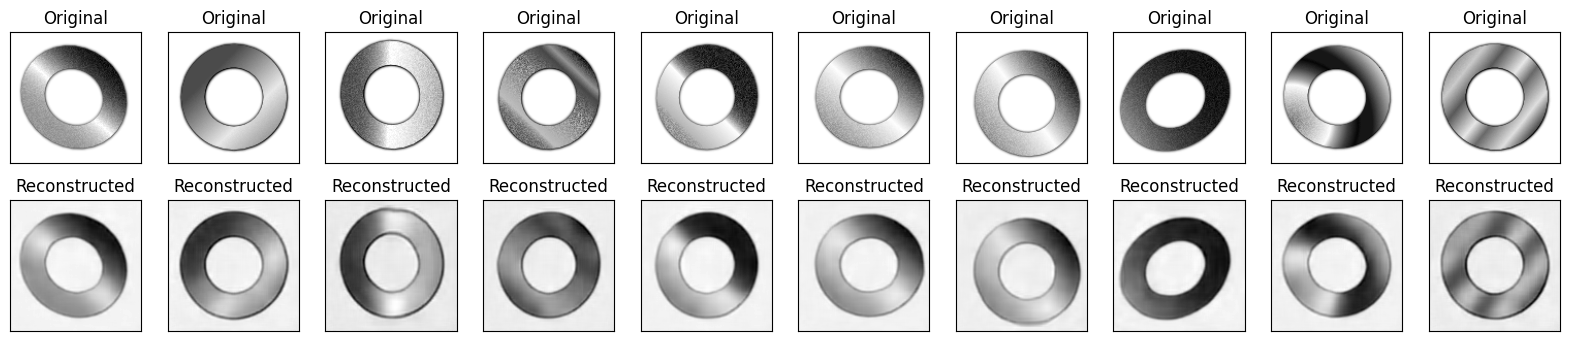

In [21]:
import matplotlib.pyplot as plt

# Predict reconstructed images
reconstructed_images = model.predict(Original_X_val)

# Number of images to display
n = 10

plt.figure(figsize=(20, 4))

for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(Original_X_val[i].reshape(128, 128, 1), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Original')

    # Display reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].reshape(128, 128, 1), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Reconstructed')

plt.show()

### Preparing Evaluation Data

In [22]:
# Path to training data
conform_path = 'data/test/conform'
anomaly_path = 'data/test/anomaly'

# List all files and subdirectories in the specified directory
conform_files = os.listdir(conform_path)
anomaly_files = os.listdir(anomaly_path)

# Empty list to store the images
images = []
labels = []

# Loop through the files list and put them into the array
for files in conform_files:
    img = cv2.imread(os.path.join(conform_path, files), cv2.IMREAD_GRAYSCALE) # full path
    images.append(img)
    labels.append(0)
for files in anomaly_files:
    img = cv2.imread(os.path.join(anomaly_path, files), cv2.IMREAD_GRAYSCALE) # full path
    images.append(img)
    labels.append(1)

# Convert to np array to work with our functions
images = np.array(images)
labels = np.array(labels)

# Shuffle the data
indices = np.arange(images.shape[0])
np.random.shuffle(indices)
images = images[indices]
labels = labels[indices]

# Preprocess
images = images.reshape(images.shape[0], 128, 128, 1)
images = images/255

### Evaluation

In [54]:
# Predict reconstructed images
# reconstructed_images = model.predict(Original_X_val)
# print(reconstructed_images.shape)

# Error array
erray = []

# Find the reconstruction error list
for i in range(200):
    erray.append(np.sum((reconstructed_images[i]-Original_X_val[i])**2))

# Find threshold for finding anomaly
threshold = np.percentile(erray, 99)
print("99th percentile error:", threshold)

99th percentile error: 20.038989770141754


In [46]:
correct = 0
incorrect = 0
total = 200

predictions = []

# Accuracy check
for image, label in zip(images,labels):
    image = image.reshape(1,128,128,1)
    reconstruction_error = np.sum((model.predict(image) - image)**2)
    
    # threshold
    if reconstruction_error >= threshold:
        predictions.append(1)
        if label == 1:
            correct += 1
        else:
            incorrect += 1
    else:
        predictions.append(0)
        if label == 0:
            correct +=1
        else:
            incorrect += 1

1/1 [==============================] - 0s 13ms/step


Accuracy: 0.8550
Precision: 0.9863
Recall: 0.7200
F1 Score: 0.8324


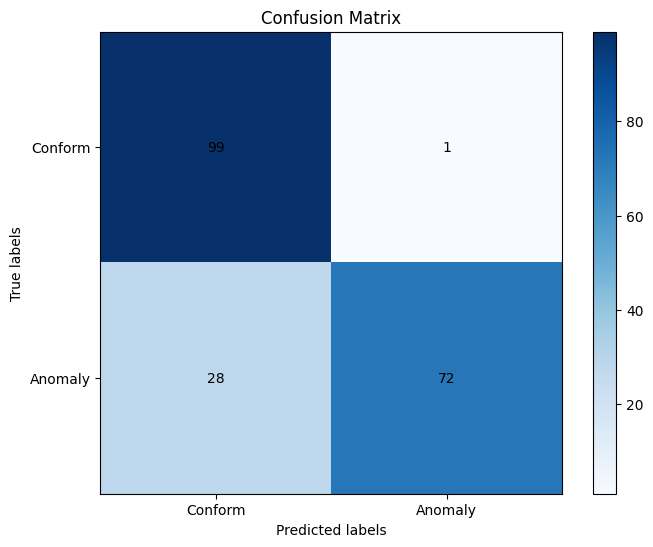

In [73]:
predictions = np.array(predictions)

# Calculate metrics
accuracy = accuracy_score(labels, predictions)
precision = precision_score(labels, predictions)
recall = recall_score(labels, predictions)
f1 = f1_score(labels, predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

fig, ax = plt.subplots(figsize=(8, 6))

# Display the heatmap
cax = ax.matshow(conf_matrix, cmap='Blues')

# Create colorbar
plt.colorbar(cax)

# Set labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(np.arange(len(['Conform', 'Anomaly'])))
ax.set_yticks(np.arange(len(['Conform', 'Anomaly'])))
ax.set_xticklabels(['Conform', 'Anomaly'])
ax.set_yticklabels(['Conform', 'Anomaly'])

# Loop over data dimensions and create text annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(j, i, str(conf_matrix[i, j]),
                ha="center", va="center", color="black")

plt.show()

### Analysis

1/1 [==============================] - 0s 13ms/step


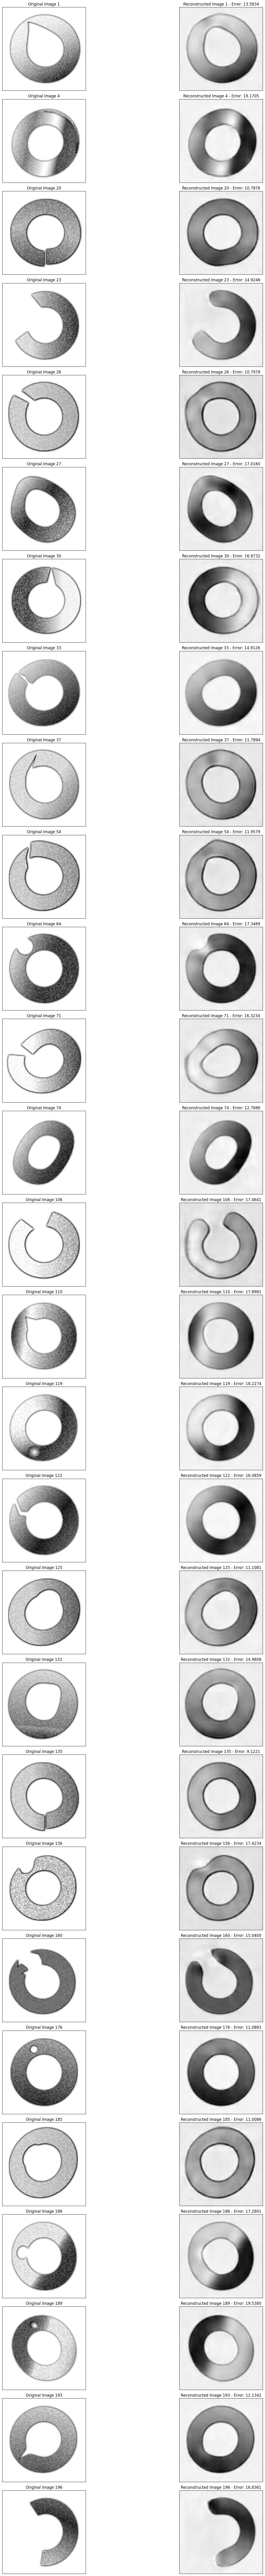

In [77]:
# Catch the False Negatives
fn_indices = []  # List to store indices of False Negatives

# Iterate over both labels and predictions using their index
for i in range(len(labels)):
    true = labels[i]
    pred = predictions[i]
    
    # Check if the instance is a False Negative
    if true == 1 and pred == 0:
        fn_indices.append(i)

fn_images = images[fn_indices]

# Number of images to display
n = len(fn_indices)

plt.figure(figsize=(20, 4 * n))

for idx, image_idx in enumerate(fn_indices):
    # Display original images
    ax = plt.subplot(n, 2, 2 * idx + 1)
    plt.imshow(images[image_idx].reshape(128, 128), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f'Original Image {image_idx}')

    # Display reconstructed images
    ax = plt.subplot(n, 2, 2 * idx + 2)
    reconstructed_image = model.predict(images[image_idx].reshape(1, 128, 128, 1))
    error = np.sum((reconstructed_image - images[image_idx].reshape(1, 128, 128, 1))**2)
    plt.imshow(reconstructed_image.reshape(128, 128), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f'Reconstructed Image {image_idx} - Error: {error:.4f}')

plt.tight_layout()
plt.show()

